# ESML - accelerator: Batch scoring pipeline
- 1) `AutoMap datalake` & init ESML project
- 2) `Get earlier trained model`
- 3) `Score with GOLD_TEST` and calculate ML-performance




######  NB! This,InteractiveLoginAuthentication, is only needed to run 1st time, then when ws_config is written, use later CELL in notebook, that just reads that file
import repackage
repackage.add("../azure-enterprise-scale-ml/esml/common/")
from azureml.core import Workspace
from azureml.core.authentication import InteractiveLoginAuthentication
from esml import ESMLDataset, ESMLProject

p = ESMLProject()
p.dev_test_prod="dev"
auth = InteractiveLoginAuthentication(tenant_id = p.tenant)
ws, config_name = p.authenticate_workspace_and_write_config(auth)
######  NB!

In [2]:
unregister_all_datasets=True

In [3]:
import repackage
repackage.add("../azure-enterprise-scale-ml/esml/common/")
from esml import ESMLDataset, ESMLProject
import pandas as pd 
from azureml.core import Workspace

from esml import ESMLDataset, ESMLProject

p = ESMLProject() # Will search in ROOT for your copied SETTINGS folder '../../../settings', you should copy template settings from '../settings'
ws = p.get_workspace_from_config() #2) Load DEV or TEST or PROD Azure ML Studio workspace

if(unregister_all_datasets):
    p.unregister_all_datasets(ws) # For DEMO purpose
    

Using GEN2 as Datastore
Unregister Azure ML dataset for ESML dataset ds01_diabetes
- IN name: M03_ds01_diabetes_IN
- Bronze name: M03_ds01_diabetes_BRONZE
- Silver name: M03_ds01_diabetes_SILVER
Gold name: M03_GOLD 


In [4]:
p.describe()

Inference version: 1

 - ds01_diabetes
projects/project002/03_diabetes_model_reg/inference/1/ds01_diabetes/in/dev/2021/06/08/
projects/project002/03_diabetes_model_reg/inference/1/ds01_diabetes/out/bronze/dev/
projects/project002/03_diabetes_model_reg/inference/1/ds01_diabetes/out/silver/dev/
projects/project002/03_diabetes_model_reg/inference/1/ds01_diabetes/in/dev/2021/06/08/
 

Training GOLD
projects/project002/03_diabetes_model_reg/inference/1/gold/dev/
 

A)INFERENCE ONLINE: GOLD to score (example if realtime - today)
projects/project002/03_diabetes_model_reg/inference/1/gold/dev/2021_06_14/70faa592977547a5b5d30ab841ea428a/
 

A)INFERENCE ONLINE: GOLD scored (example if realtime today)
projects/project002/03_diabetes_model_reg/inference/1/scored/dev/2021_06_14/70faa592977547a5b5d30ab841ea428a/
 

B)INFERENCE BATCH: GOLD to score (example batch, datetime from config)
projects/project002/03_diabetes_model_reg/inference/1/gold/dev/2021_06_08/617554e219a9418daaec84a2b785749d/
 

B)INF

In [5]:
p.inference_mode = False
datastore = p.init(ws) # 3) Automapping from datalake to Azure ML datasets

...
Using GEN2 as Datastore
Searching for setting in ESML datalake...
ESML in-folder settings override = TRUE 
 - Found settings in the ESML AutoLake  [active_in_folder.json,active_scoring_in_folder.json], to override ArgParse/GIT config with.
 - TRAIN in date:  2021/01/01
 - INFERENCE in date: 2021/06/08 and ModelVersion to score with: 1 (0=latest)

Load data as Datasets....
ds01_diabetes

####### Automap & Autoregister - SUCCESS!
1) Auto mapped 1 ESML Dataset with registered Azure ML Datasets (potentially all 3: IN,BRONZE, SILVER) in Datastore project002 

Dataset 'ds01_diabetes' status:
 - IN_Folder_has_files
 - BRONZE_Folder_has_files
 - SILVER_Folder_has_files

2) Registered each Dataset with suffixes (_IN, _BRONZE, _SILVER) 
 Tip: Use ESMLProject.Datasets list or .DatasetByName(myDatasetName) to read/write
#######


In [6]:
# Feture engineering: Bronze 2 Gold - working with Azure ML Datasets with Bronze, Silver, Gold concept
esml_dataset = p.DatasetByName("ds01_diabetes") # Get dataset
df_bronze = esml_dataset.Bronze.to_pandas_dataframe()
p.save_silver(esml_dataset,df_bronze) #Bronze -> Silver

df = esml_dataset.Silver.to_pandas_dataframe() 
df_filtered = df[df.AGE > 0.015] 
gold_train = p.save_gold(df_filtered)  #Silver -> Gold

## SUMMARY - step 1
- ESML has now `Automap` and `Autoregister` Azure ML Datasets as: `IN, SILVER, BRONZE, GOLD`
- ESML has read configuration for correct environment (DEV, TEST, PROD). 
    - Both small customers, and large Enterprise customers often wants:  DEV, TEST, PROD in `diffferent Azure ML workspaces` (and different subscriptions)
- User has done feature engineering, and saved GOLD `p.save_gold`

# 2) `Regression` - Get diabetes model
https://docs.microsoft.com/en-us/azure/synapse-analytics/spark/apache-spark-azure-machine-learning-tutorial

In [7]:
from esml import ESMLDataset, ESMLProject
from baselayer_azure_ml import azure_metric_regression,azure_metric_classification
from azureml.train.automl import AutoMLConfig

label = "Y"

# TEST_SET scoring: REGRESSION
 - Autoregisters in Azure ML Studio, the TEST-scoring as TAGS on the GOLD_TEST dataset i
 - locally on build server, or via pipeline.

Loading AutoML config settings from: dev
Package:azureml-automl-runtime, training version:1.29.0, current version:1.26.0
Package:azureml-core, training version:1.29.0, current version:1.26.0
Package:azureml-dataprep, training version:2.15.1, current version:2.13.2
Package:azureml-dataprep-native, training version:33.0.0, current version:32.0.0
Package:azureml-dataprep-rslex, training version:1.13.0, current version:1.11.2
Package:azureml-dataset-runtime, training version:1.29.0, current version:1.26.0
Package:azureml-defaults, training version:1.29.0, current version:1.26.0
Package:azureml-interpret, training version:1.29.0, current version:1.26.0
Package:azureml-pipeline-core, training version:1.29.0, current version:1.26.0
Package:azureml-telemetry, training version:1.29.0, current version:1.26.0
Package:azureml-train-automl-client, training version:1.29.0, current version:1.26.0
Package:azureml-train-automl-runtime, training version:1.29.0, current version:1.26.0
Replacing tag run_i

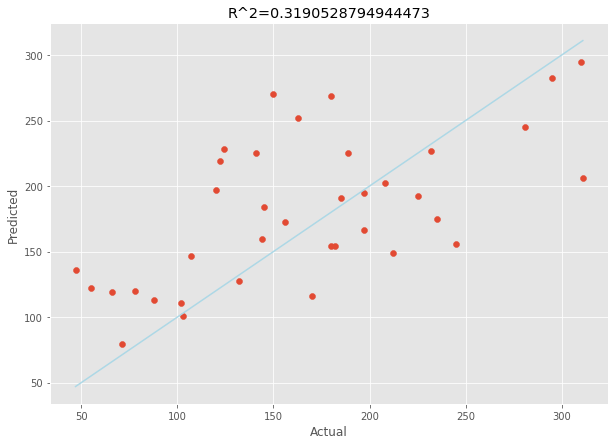

In [10]:
from baselayer_azure_ml import ESMLPipelineFactory

p.split_gold_3(0.6,label)
rmse, r2, mean_abs_percent_error,accuracy,plt = ESMLPipelineFactory(p).get_test_scoring_4_regression(label)
print("RMSE:")
print(rmse)
print()
print("R2:")
print(r2)
print()
print("MAPE:")
print(mean_abs_percent_error)
print()
print("Accuracy:")
print(accuracy)

In [11]:
print("From Azure ML Dataset - fetch from Azure ML Studio Dataset tags")
print("RMSE", p.GoldTest.tags["RMSE"])

From Azure ML Dataset - fetch from Azure ML Studio Dataset tags
RMSE 57.16943442166354


In [12]:
print("From MODEL - fetch from Azure ML Studio MODEL tags")
print("Model name: ", p.BestModel.name)
print("RMSE", p.BestModel.tags["test_set_RMSE"])

From MODEL - fetch from Azure ML Studio MODEL tags
Loading AutoML config settings from: dev
Package:azureml-automl-runtime, training version:1.29.0, current version:1.26.0
Package:azureml-core, training version:1.29.0, current version:1.26.0
Package:azureml-dataprep, training version:2.15.1, current version:2.13.2
Package:azureml-dataprep-native, training version:33.0.0, current version:32.0.0
Package:azureml-dataprep-rslex, training version:1.13.0, current version:1.11.2
Package:azureml-dataset-runtime, training version:1.29.0, current version:1.26.0
Package:azureml-defaults, training version:1.29.0, current version:1.26.0
Package:azureml-interpret, training version:1.29.0, current version:1.26.0
Package:azureml-pipeline-core, training version:1.29.0, current version:1.26.0
Package:azureml-telemetry, training version:1.29.0, current version:1.26.0
Package:azureml-train-automl-client, training version:1.29.0, current version:1.26.0
Package:azureml-train-automl-runtime, training version

# TEST SCORE END - REGRESSION

# 3) TEST_SET scoring (pipeline with remote CPU cluster)

In [ ]:
aml_compute = p.get_training_aml_compute(ws) # 2)Get compute, for active environment
rmse, r2, mean_abs_percent_error,accuracy,plt = ESMLPipelineFactory(p).get_test_scoring_4_regression(label,aml_compute)

# END